In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
sns.set()

In [2]:
df_train = pd.read_csv('CompetenciaECI/Entrenamieto_ECI_2020.csv', index_col = 'Opportunity_ID')
df_val = pd.read_csv('CompetenciaECI/Validacion_ECI_2020.csv', index_col = 'Opportunity_ID')
target = 'Stage'
predictors = [x for x in df_train.columns if x not in [target]]
y = df_train.loc[:,target].copy()
y = (y=='Closed Won') * 1 
df_train = df_train.loc[:, predictors]
df = pd.concat([df_train,df_val], axis=0)
print('Tamaños de entrenamiento')
print(f'Tamanio de X: {df_train.shape}')
print(f'Tamanio de X_val: {df_val.shape}')
print(f'Tamanio de y: {y.shape}')

Tamaños de entrenamiento
Tamanio de X: (16947, 50)
Tamanio de X_val: (2551, 50)
Tamanio de y: (16947,)


## Valores faltantes

In [ ]:
def nan_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(6))
nan_values(df_train)
nan_values(df_val)
nan_values(df)

## Analisis de variables numericas 

## Valores None en variables numericas

In [ ]:
numerical_cols = ['Sales_Contract_No', 'ASP', 'ASP_(converted)', 
              'TRF', 'Total_Amount', 'Total_Taxable_Amount', 'ID']

In [ ]:
def none_values(df):
    df_num = df[numerical_cols]
    total = df_num.apply(lambda x: x=='None').sum().sort_values(ascending=False)
    percent = (total/df_num.apply(lambda x: x=='None').count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(12))
none_values(df_train)
none_values(df_val)
none_values(df)

## Analisis de variables categoricas 

In [ ]:
binary_cols = ['Pricing, Delivery_Terms_Quote_Appr', 'Pricing, Delivery_Terms_Approved', 
           'Bureaucratic_Code_0_Approval','Bureaucratic_Code_0_Approved']

categorical_cols = ['Region','Territory','Bureaucratic_Code', 
                'Source ','Billing_Country','Account_Name',
                'Opportunity_Name', 'Account_Owner',
               'Opportunity_Owner','Account_Type', 'Opportunity_Type', 
                'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 
                'Size','Product_Category_B', 'Currency', 'Last_Modified_By',
                'Product_Family', 'Product_Name', 'ASP_Currency',
                'ASP_(converted)_Currency','Delivery_Quarter',
                'Total_Taxable_Amount_Currency',
                'Prod_Category_A', 'Total_Amount_Currency'
               ]
cols = binary_cols + categorical_cols

In [ ]:
for d in [df, df_train, df_val]:
    d[cols] = d[cols].astype('category')

### Como cambian las variables categoricas dentro de una misma oportunidad

In [ ]:
# Que categorias tienen presentes diferentes valores en una misma oportunidad?
# Product_Family, Product_Name y Delivery_Quarter

d = df.select_dtypes(include=['category'])
group = d.groupby(d.index)
for col in d.columns:
    print(col)
    print(group[col].apply(lambda x: len(set(x))!=1).sum())

## Valores None en columnas categoricas/binarias

In [ ]:
#df[numerical_cols] = df[numerical_cols].astype('float64')
def none_values(df):
    df_cat = df[cols]
    total = df_cat.apply(lambda x: x=='None').sum().sort_values(ascending=False)
    percent = (total/df_cat.apply(lambda x: x=='None').count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(12))
none_values(df_train)
none_values(df_val)
none_values(df)

## Relacion entre las categorias y la variable objetivo

In [ ]:
d = pd.concat([df_train, y], axis=1)
for col in d.select_dtypes(include='category').columns:
    groups = d.groupby(col)
    print(d.groupby(col).agg({col:'count', 'Stage':'mean'}).sort_values('Stage', ascending=False).head(30))


### Cantidad de categorias por variable categorica

In [ ]:
df.select_dtypes(include='category').nunique().sort_values(ascending=False)

### Relation Region/Territorio
- Cuanto el Territorio es None la region en gral es Japan
- Japon tiene su propio territorio
- Hay 5000 Nones en Territorio, siendo la mayoria de la region Japan
- Decision: se completan los Nones con el nombre de las Region

In [ ]:
# territorios por region
df.loc[:,['Territory','Region']].groupby('Region')['Territory'].apply(set)

In [ ]:
# a que region corresponden los valores nulos de los territorios?
df.loc[df['Territory']=='None',['Territory','Region']].groupby('Region')['Region'].count()

In [ ]:
# cuando la region es japon, hay muchos nones 
df.loc[df['Region']=='Japan',['Territory','Region']].groupby('Territory')['Territory'].count().sort_values(ascending=False)

## Cantidad de registros por tipo en cada categoria y cantidad de categorias

In [ ]:
def print_categorical_values(cat):
    groups = df.groupby([cat])[cat]
    print(groups.size().sort_values(ascending=False))
    print(len(groups))
    print()

In [ ]:
for cat in categorical_cols:
    print_categorical_values(cat)

## Analisis variables fechas

In [3]:
datetime_cols = ['Account_Created_Date', 'Opportunity_Created_Date',
             'Last_Activity','Quote_Expiry_Date', 'Last_Modified_Date',
             'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date',
             'Actual_Delivery_Date']

In [4]:
for d in [df,df_val,df_train]:
    for col in datetime_cols:
        d[col] = pd.to_datetime(d[col])

In [5]:
d = df.select_dtypes(include=['datetime'])
group = d.groupby(d.index)
for col in d.columns:
    print(col)
    print(group[col].apply(lambda x: len(set(x))!=1).sum())

Account_Created_Date
0
Opportunity_Created_Date
0
Last_Activity
0
Quote_Expiry_Date
0
Last_Modified_Date
0
Planned_Delivery_Start_Date
969
Planned_Delivery_End_Date
1014
Actual_Delivery_Date
0


Opportunity_ID
0        92.0
1        93.0
2        96.0
3        97.0
4        98.0
         ... 
12799    96.0
12800    97.0
12801    98.0
12802    95.0
12803    94.0
Name: count, Length: 9841, dtype: float64

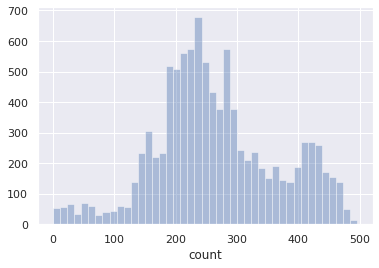

In [64]:
d = df_train
d = d.groupby(d.index).Opportunity_Created_Date.first().to_frame('date')
d_date = pd.Series(d.index, index=d.date, name='count').sort_index()
count = d_date.rolling('30d').count() - 1
sns.distplot(count, kde=False)
count.index = d_date.values
count.reindex(d.index)

12369     0.0
12370     0.0
12371     0.0
12372     0.0
12373     1.0
         ... 
11196    32.0
11200    33.0
11205    25.0
11215     4.0
11218     4.0
Name: count, Length: 9841, dtype: float64

In [6]:
df[datetime_cols].isna().sum()

Account_Created_Date               0
Opportunity_Created_Date           0
Last_Activity                  19498
Quote_Expiry_Date               5861
Last_Modified_Date                 0
Planned_Delivery_Start_Date        0
Planned_Delivery_End_Date        126
Actual_Delivery_Date           19498
dtype: int64

In [11]:
for col in datetime_cols:
    s = pd.Series(df.index, index=df[col], name=col)
    print(s.groupby(s.index).size().sort_values(ascending=False).head(20))
    

Account_Created_Date
2013-07-27    3061
2015-04-20    3014
2013-09-23     610
2014-09-19     397
2015-12-21     365
2013-08-22     327
2013-07-28     307
2013-10-03     276
2016-09-28     236
2016-01-29     215
2016-03-03     200
2017-02-20     183
2013-09-05     147
2015-10-30     123
2016-07-11     113
2015-06-17     112
2014-02-28     112
2017-07-05     102
2017-05-20      99
2016-04-18      97
Name: Account_Created_Date, dtype: int64
Opportunity_Created_Date
2017-06-30    124
2016-01-22    107
2017-05-09    104
2016-05-18     99
2016-01-07     89
2018-01-30     87
2017-10-02     86
2017-04-20     83
2019-04-11     83
2017-12-06     82
2017-10-24     80
2017-03-15     80
2017-05-15     77
2019-01-17     76
2016-02-15     76
2016-01-06     74
2017-05-02     73
2017-12-08     72
2018-05-04     72
2019-02-07     71
Name: Opportunity_Created_Date, dtype: int64
Series([], Name: Last_Activity, dtype: int64)
Quote_Expiry_Date
2017-06-30    436
2017-03-31    363
2017-09-30    225
2016-12-31

In [ ]:
def none_values(df):
    f = lambda x: x.isnull()
    df_date = df[datetime_cols]
    total = df_date.apply(f).sum().sort_values(ascending=False)
    percent = (total/df_date.apply(f).count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
none_values(df_train)
none_values(df_val)
none_values(df)

In [ ]:
# Quiero ver cual es la relacion entre Quote_Expiry_Date y la variable objectivo
# en 12mil de los casos de entrenamiento, cuando la fecha de vencimiento del presupuesto esta seteada, la oportunidad se gana
quote_not_set = df_train['Quote_Expiry_Date'].isnull()
print((quote_not_set != y.astype('bool')).sum())

# y siempre se mantiene igual para la misma oportunidad
print(quote_not_set.groupby(quote_not_set).apply(lambda x: len(set(x))!=1).sum())

In [ ]:
# Las unicas variables de fecha que varian para una misma son Planned_Delivery_Start_Date y Planned_Delivery_End_Date
d = pd.concat([df_train, df_val], axis=0).select_dtypes(include=['datetime'])
for col in d.columns:
    print(col)
    print(d.groupby(d.index)[col].apply(lambda x: len(set(x))>1).sum())

## Posibles target leackage
- Submitted_for_Approval: casi toda 0
- Delivery_Terms: nop
- Quote_Expiry_Date
- Actual_Delivery_Date: es puro NaT
- Total_Power: no esta en el dataset (tampoco la categorica correspondiente)
- Sales_Contract_No

In [ ]:
# los tipos de terminos no muestran un especial inclinacion haciia las oportunidades perdidas o ganadas
d = pd.concat([df_train, y], axis=1)
d.groupby('Delivery_Terms').agg({'Delivery_Terms':'count', 'Stage':'mean'}).sort_values('Stage', ascending=False)

In [15]:
# Esta parece ser el target Leackage, los productos que 
# no tienen Sales_Contract_No tienen un bajisimo numero de exito
d = pd.concat([df_train, y], axis=1).loc[:,['Sales_Contract_No','Stage']]
d = d.groupby(d.index).first()
d['isNone'] = d.Sales_Contract_No == 'None'
d = d.groupby('isNone').agg(['count','mean'])
d.sort_values(d.columns[0], ascending=False)
# sigo en la proxima celda

Stage          
       count      mean
isNone                
False   5266  0.943980
True    4575  0.022077

In [14]:
# Esta parece ser el target Leackage, los productos que 
# no tienen Sales_Contract_No tienen un bajisimo numero de exito
d = pd.concat([df_train, y], axis=1).loc[:,['Quote_Expiry_Date','Stage']]
d = d.groupby(d.index).first()
d['isNone'] = d['Quote_Expiry_Date'].isnull()
d = d.groupby('isNone').agg(['count','mean'])
d.sort_values(d.columns[0], ascending=False)
# sigo en la proxima celda

Stage          
       count      mean
isNone                
False   7489  0.569769
True    2352  0.342262

In [ ]:
d = pd.concat([df_train, df_val], axis=0)
d.Sales_Contract_No == 'None'